In [2]:
%matplotlib inline

## Do cross validation

In [3]:
# load data
from surprise import Dataset, Reader
train_reader = Reader(line_format='item rating user', sep=',',skip_lines=1) 
train_file = '../data/data_train_surprise.csv'
train_data = Dataset.load_from_file(train_file, reader=train_reader)


In [31]:
# do cross validation
from surprise import SVD
from surprise.accuracy import rmse
import numpy as np
from surprise.evaluate import evaluate

n_factors = 12 # The number of factors. Default is 100.
n_epochs  = 20 # The number of iteration of the SGD procedure. Default is 20.
biased    = True # Whether to use baselines (or biases). See note above. Default is True.
lr_all = 0.005 # The learning rate for all parameters. Default is 0.005.
reg_all   = 0.0359 # The regularization term for all parameters. Default is 0.02.
train_data.split(n_folds=2)
algo = SVD(n_factors=n_factors,n_epochs=n_epochs,lr_all=lr_all,reg_all=reg_all)
perf=evaluate(algo, train_data, measures=['rmse'], with_dump=False, dump_dir=None, verbose=1)

# nepoch K   lr_all  reg_all  rmse 
# 120    40  0.001   0.00005  0.9984
# 80     40  0.001   0.00005  0.9999 
# 80     40  0.01    0.00005  1.0105 
# 80     40  0.01    0.02     1.0058
# 80     40  0.01    0.2      1.0071 
# 40     40  0.001   0.2      1.0042
# 80     40  0.001   0.2      1.0043
# 120    40  0.001   0.2      1.0047
# 40    100  0.001   0.00005  1.0013     
# 80    100  0.001   0.0005   1.0017 
# 120    100  0.001   0.0005  1.0002 
# 120    100  0.001   0.005   
# 120    40  0.001   0.0005   1.0016 
# 120    40  0.001   0.00001  1.0032 

Evaluating RMSE of algorithm SVD.



KeyboardInterrupt: 

In [5]:
import pickle
dump_obj1 = pickle.load(open('/home/kiki/.surprise_data/dumps/161219-22h03m53-SVD-fold1', 'rb'))
dump_obj2 = pickle.load(open('/home/kiki/.surprise_data/dumps/161219-22h06m05-SVD-fold2', 'rb'))
dump_obj3 = pickle.load(open('/home/kiki/.surprise_data/dumps/161219-22h08m15-SVD-fold3', 'rb'))
predictions1 = dump_obj1['predictions']
trainset1 = dump_obj1['trainset']
algo1 = dump_obj1['algo']
predictions2 = dump_obj2['predictions']
trainset2 = dump_obj2['trainset']
algo2 = dump_obj2['algo']
predictions3 = dump_obj3['predictions']
trainset3 = dump_obj3['trainset']
algo3 = dump_obj3['algo']
df1 = pd.DataFrame(predictions1, columns=['uid', 'iid', 'rui', 'est', 'details'])    
df2 = pd.DataFrame(predictions2, columns=['uid', 'iid', 'rui', 'est', 'details'])    
df3 = pd.DataFrame(predictions3, columns=['uid', 'iid', 'rui', 'est', 'details'])    
print('algo: {0}, k = {1}, min_k = {2}'.format(algo['name'], algo['k'], algo['min_k']))


In [33]:
def evaluate_k_fold(n_factors, n_epochs, lr_all, reg_all):
    algo = SVD(n_factors=n_factors,n_epochs=n_epochs,lr_all=lr_all,reg_all=reg_all)
    algo.bsl_options['biased'] = biased
    n_folds = 3
    train_data.split(n_folds=n_folds)
    rmses_test = []
    for trainset, testset in train_data.folds():
        # train and test algorithm.
        algo.train(trainset)
        predictions_test = algo.test(testset)
        # Compute and print Root Mean Squared Error
        rmse_test_k = rmse(predictions_test, verbose=False)
        rmses_test.append(rmse_test_k)
    rmse_test = np.mean(rmses_test) 
    return rmse_test

results_path = '../results/SGD_surprise/'
n_factors_range = np.array([10,15,20])#np.linspace(10,30,21)
reg_all_range = np.logspace(-1.9,-1.3,10)
n_epochs_range = np.arange(10,50,10)
rmses = np.empty((len(n_factors_range),len(reg_all_range), len(n_epochs_range)))
for i,n_factors in enumerate(n_factors_range):
    print('testing with n_factors={}'.format(n_factors))
    for j,reg_all in enumerate(reg_all_range):
        print('testing with reg_all={}'.format(reg_all))
        for k,n_epochs in enumerate(n_epochs_range):
            print('testing with n_epochs={}'.format(n_epochs))
            rmses[i,j,k] = evaluate_k_fold(int(n_factors),n_epochs,lr_all, reg_all)
            print('rmse={}'.format(rmses[i,j,k]))
        results_name = 'rmse_{}_{}'.format(n_factors, reg_all)
        np.savetxt(results_path + results_name + '.csv', rmses[i,j,:], delimiter=",")

testing with n_factors=10
testing with reg_all=0.012589254117941675
testing with reg_all=10
rmse=0.9989463783176515
testing with reg_all=20
rmse=0.9984136625073279
testing with reg_all=30
rmse=0.9988734979425348
testing with reg_all=40
rmse=0.9996382553856268
testing with reg_all=0.014677992676220698
testing with reg_all=10
rmse=0.9991246479643552
testing with reg_all=20
rmse=0.9981299789662302
testing with reg_all=30
rmse=0.9990841172687176
testing with reg_all=40
rmse=0.9993101745374728
testing with reg_all=0.01711328304161781
testing with reg_all=10
rmse=0.9992654310772076
testing with reg_all=20
rmse=0.998044209443124
testing with reg_all=30
rmse=0.9983866513189844
testing with reg_all=40
rmse=0.9987400073628244
testing with reg_all=0.0199526231496888
testing with reg_all=10
rmse=0.9996673973848167
testing with reg_all=20
rmse=0.9977781616557871
testing with reg_all=30
rmse=0.9982592649360004
testing with reg_all=40
rmse=0.9987148053112479
testing with reg_all=0.02326305067153626
t

(3, 10, 4)
(3, 10, 4)
(3, 10, 4)
(3,)
(10,)
../results/SGD_surprise/rmse_40_0.005_[ 0.01258925  0.01467799  0.01711328  0.01995262  0.02326305  0.02712273
  0.03162278  0.03686945  0.04298662  0.05011872]_[10 15 20].png


TypeError: Mismatch between array dtype ('float64') and format specifier ('%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e')

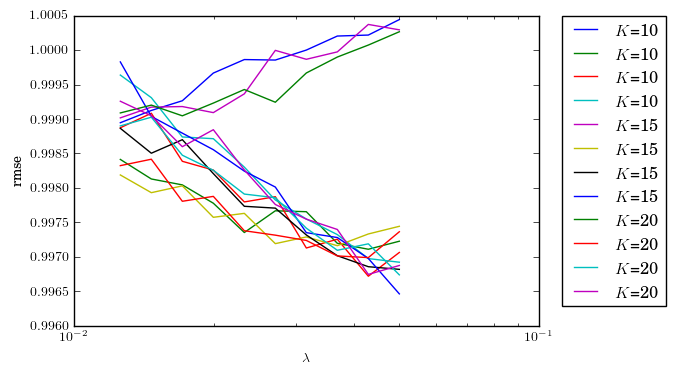

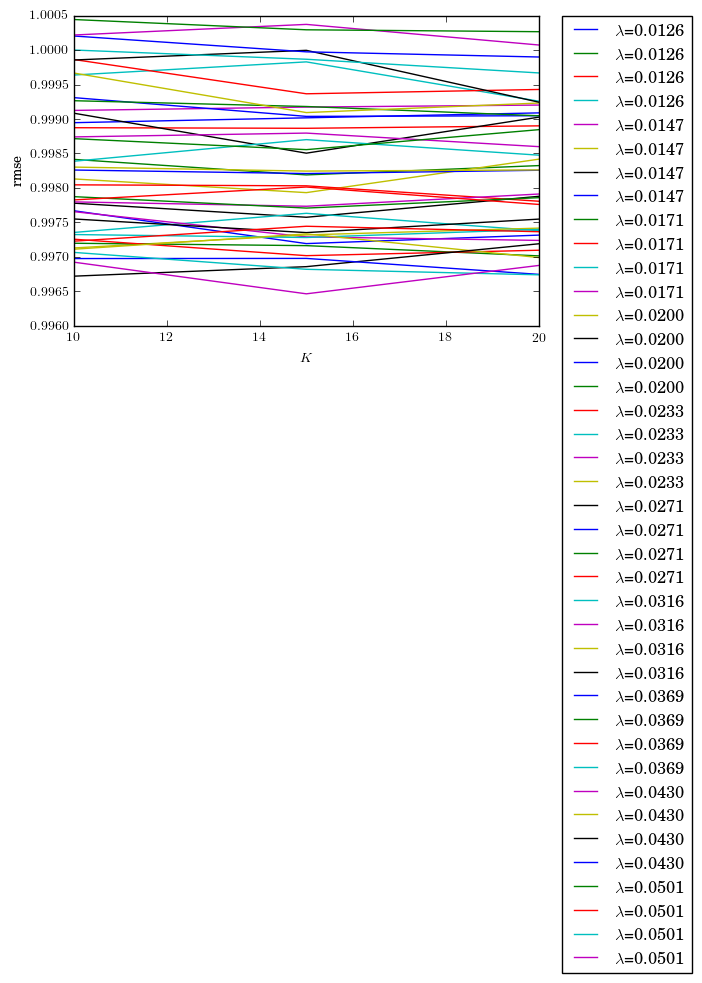

In [36]:
print(rmses_clipped.shape)
rmses_clipped = rmses
results_path = '../results/SGD_surprise/'
results_name = 'rmse_{}_{}_{}_{}'.format(n_epochs,lr_all,n_factors_range,reg_all_range)
np.save(results_path + results_name + '.csv', rmses_clipped)
#np.savetxt(results_path + results_name + '.csv', rmses_clipped, delimiter=",")
#test_rmses_clipped = np.loadtxt(results_path + results_name + '.csv', delimiter =',')
#assert np.isclose(test_rmses_clipped,rmses_clipped).all()

print(rmses_clipped.shape)
print(rmses.shape)
print(n_factors_range.shape)
print(reg_all_range.shape)

# Plot results
import matplotlib.pyplot as plt

num_n_factors = rmses_clipped.shape[0]
num_reg_all = rmses_clipped.shape[1]

plt.rc('text', usetex=True)
plt.rc('font', family='verdana')

fig = plt.figure()
for i in range(num_n_factors):
    plt.semilogx(reg_all_range,rmses_clipped[i,:],label='$K$={}'.format(n_factors_range[i]))
plt.xlabel('$\lambda$')
plt.ylabel('rmse')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
fig.savefig(results_path + 'lambda_' + results_name + '.png')

fig = plt.figure()
for i in range(num_reg_all):
    plt.plot(n_factors_range,rmses_clipped[:,i],label='$\lambda$={:1.4f}'.format(reg_all_range[i]))
plt.xlabel('$K$')
plt.ylabel('rmse')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
print(results_path + 'rmse_{}_{}_{}_{}.png'.format(n_epochs,lr_all,reg_all_range,n_factors_range))
fig.savefig(results_path + 'K_' + results_name + '.png')
#fig, axis = plt.subplots(1,num_n_factors) 
#for i,ax in enumerate(axis):
#    ax.semilogx(reg_all_range,rmses_clipped[i,:])
#    ax.set_title('{}'.format(n_factors_range[i]))
#plt.legend()
#    
#fig, axis = plt.subplots(1,num_reg_all) 
#for i,ax in enumerate(axis):
#    ax.plot(n_factors_range,rmses_clipped[:,i])
#    ax.set_title('{}'.format(reg_all_range[i]))

np.savetxt(results_path + results_name + '.csv', rmses_clipped, delimiter=",")
test_rmses_clipped = np.loadtxt(results_path + results_name + '.csv', delimiter =',')
assert np.isclose(test_rmses_clipped,rmses_clipped).all()

##  Train on whole data

In [25]:
# load data
from surprise import Dataset, Reader
fold_reader = Reader(line_format='item rating user', sep=',',skip_lines=1) 
# fold_files = [(train_set, test_set)]
fold_files = [('../data/data_train_surprise.csv', '../data/sampleSubmission_surprise.csv')]
fold_data = Dataset.load_from_folds(fold_files, reader=fold_reader)

In [26]:
# train algorithm.
from surprise import SVD
from surprise.accuracy import rmse
from surprise.dump import dump
n_factors = 12 # The number of factors. Default is 100.
n_epochs  = 20 # The number of iteration of the SGD procedure. Default is 20.
biased    = True # Whether to use baselines (or biases). See note above. Default is True.
lr_all = 0.005 # The learning rate for all parameters. Default is 0.005.
reg_all   = 0.0359 # The regularization term for all parameters. Default is 0.02.
algo = SVD(n_factors=n_factors,n_epochs=n_epochs,lr_all=lr_all,reg_all=reg_all)
for (trainset, testset) in fold_data.folds():
    print('training SVD...')
    algo.train(trainset)
    print('testing SVD...')
    predictions_svd = algo.test(testset)
    #rmse(predictions_svd)
    dump('../results/dump_SVD', predictions_svd, trainset, algo)

training SVD...
testing SVD...
The dump has been saved as file ../results/dump_SVD


## Save submission

In [ ]:
# create correct format
import pickle
import pandas as pd
dump_obj_svd = pickle.load(open('../results/dump_SVD', 'rb'))
df_svd = pd.DataFrame(dump_obj_svd['predictions'], columns=['uid', 'iid', 'rui', 'est', 'details'])    
#df_svd['err'] = abs(df_svd.est - df_svd.est.round())
#print(df_svd.where(df_svd['err']<0.001))
#if (df_svd['err']<0.001):
    #df_svd['est'] = df_svd['est'].round()
#print(df_svd.where(df_svd['err']<0.001))

print('Raw: \n',df_svd.head())
df_svd["Id"] = "r" + df_svd["iid"].map(str) + "_c" +df_svd["uid"].map(str)

# TODO: choose if we want to round or not. 
#df_svd["Prediction"] = df_svd["est"].clip(0,5) #round()
df_svd["Prediction"] = df_svd["est"].clip(0,5)

In [30]:
df_svd_new = df_svd.drop(["iid","uid","est","details","rui"],1)

# save submission
output_path = '../results/submission_surprise.csv'
df_svd_new.to_csv(output_path,columns=["Id","Prediction"],index=False)
print('Submission: \n',df_svd_new.head())

Submission: 
         Id  Prediction
0   r37_c1    3.404940
1   r73_c1    2.977539
2  r156_c1    3.727564
3  r160_c1    3.215529
4  r248_c1    3.509638


In [ ]:
## Save ratings matrix for all training entries
from surprise import Dataset, Reader
fold_reader = Reader(line_format='item rating user', sep=',',skip_lines=1) 
# fold_files = [(train_set, test_set)]
fold_files = [('../data/data_train_surprise.csv', '../data/data_train_surprise.csv')]
fold_data = Dataset.load_from_folds(fold_files, reader=fold_reader)
from surprise import SVD
from surprise.accuracy import rmse
from surprise.dump import dump
for (trainset, testset) in fold_data.folds():
    print('training SVD...')
    algo.train(trainset)
    print('testing SVD...')
    predictions_svd = algo.test(testset)
    #rmse(predictions_svd)
    dump('../results/dump_SVD_full', predictions_svd, trainset, algo)
import pickle
import pandas as pd
dump_obj_svd = pickle.load(open('../results/dump_SVD_full', 'rb'))
df_svd = pd.DataFrame(dump_obj_svd['predictions'], columns=['uid', 'iid', 'rui', 'est', 'details'])    
print('Raw: \n',df_svd.head())
df_svd["Id"] = "r" + df_svd["iid"].map(str) + "_c" +df_svd["uid"].map(str)
df_svd["Prediction"] = df_svd["est"].clip(0,5)
df_svd_new = df_svd.drop(["iid","uid","est","details","rui"],1)
# save submission
output_path = '../results/submission_surprise_full.csv'
df_svd_new.to_csv(output_path,columns=["Id","Prediction"],index=False)
print('Submission: \n',df_svd_new.head())